## **공유오피스 출입데이터**를 바탕으로 각 종 **비즈니스 지표의 추이를 예측**하여 **서비스의 개선 방향성을 제시**하는 프로젝트 입니다.


## Call Library

In [93]:
## data
import pandas as pd
import numpy as np
import math
from imblearn.over_sampling import SMOTE
import random
import time
import os
import glob
import math
import datetime

## visualization
import matplotlib.pyplot as plt
import seaborn as sns

## deactivate warning sign
import warnings
warnings.filterwarnings("ignore")

## ML
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer



## Load Data

In [94]:
# 파일 용량 확인
def get_csv_file_sizes(directory):
    file_sizes = {}
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            file_size_bytes = os.path.getsize(file_path)
            file_size_mb = file_size_bytes / (1024 * 1024)
            file_sizes[filename] = file_size_mb
    return file_sizes

In [ ]:
directory = '파일이 있는 위치를 지정해주세요.'

csv_file_sizes = get_csv_file_sizes(directory)
sorted_dict = dict(sorted(csv_file_sizes.items(), key=lambda item: item[1], reverse=True))
for filename, size in sorted_dict.items():
    print(f'{filename:<50}: {size:.2f} MB')

In [ ]:
start_time = time.time()

# 데이터 불러오기
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# 각 CSV 파일을 별도의 DataFrame으로 불러와서 변수에 저장
df_set = {}

# datetime_col = ['cdate', 'stay_time', 'first_enter_time', 'last_leave_time']
datetime_col = ['cdate', 'trial_date','first_enter_time', 'last_leave_time']

for file in csv_files:
    # 파일명에서 확장자를 제거하여 변수명을 생성
    var_name = os.path.splitext(file)[0]
    
    # DataFrame을 읽어서 딕셔너리에 저장
    df_set[var_name] = pd.read_csv(os.path.join(directory, file))
    
    if 'Unnamed: 0' in df_set[var_name].columns:
        df_set[var_name].drop(['Unnamed: 0'], axis=1, inplace=True)

    # for col in datetime_col:
    #     if col in df_set[var_name].columns:
    for col in [col for col in datetime_col if col in df_set[var_name].columns]:
            df_set[var_name][col] = pd.to_datetime(df_set[var_name][col], errors='coerce')  # 변환 불가능한 값은 NaT로 설정

    df_set[var_name].drop_duplicates(inplace=True)
    

for name, df in df_set.items():
    print(f"Load Succeeded DataFrame: {name}")
    # print(df.head())  

for name, df in df_set.items():
    print()
    print(f"{name} : \n{df.dtypes}")
    # print(df.head())  

end_time = time.time()
print()
print("Data 불러오기 완료!")
print(str(round(end_time - start_time, 2)) + "s", '데이터 불러오는데 걸리는 시간')

In [ ]:
for col in df_set.keys():
    missing_ratio = df_set[col].isnull().sum() / df_set[col].shape[0] * 100
    print(f'{col} 데이터의 결측치 비율은 : \n{missing_ratio}\n')

In [ ]:
for idx in df_set.keys():
    data_size = df_set[idx].shape
    print(f'{idx}의 데이터 사이즈는 : \n{data_size}\n')

In [99]:
## 데이터 들
register_df = df_set['trial_register']
visit_info_df = df_set['trial_visit_info'] 
site_area_df = df_set['site_area']
payment_df = df_set['trial_payment']
access_log_df = df_set['trial_access_log']

visit_info = df_set['trial_visit_info']

### trial_register

In [ ]:
register_df

In [ ]:
# 유저별 2번나온 경우
register_count = register_df['user_uuid'].value_counts()

register_count_df = register_count.reset_index()
register_count_df.columns = ['user_uuid', 'Count']

display(register_count_df)

In [ ]:
## user_uuid를 기반으로 하여서 trial_date를 list형태로 받음.
register_reservation_dates = register_df.groupby('user_uuid')['trial_date'].apply(list).reset_index()

register_count_df = register_count_df.merge(register_reservation_dates, on='user_uuid', how='left')
register_count_df

In [ ]:
## Count가 2회인 유저 확인. 해당 유저만 뽑아서 로그에 확인해볼 것
register_error_df = register_count_df[register_count_df['Count'] == 2]
register_error_df

In [ ]:
error_user = register_error_df['user_uuid'].tolist() # user_id만 추출
visit_info_df[visit_info_df['user_uuid'].isin(error_user)] 
## 확인 결과 Count가 2회인 유저의 경우에 trial_date가 가장 최근을 기준으로. 

In [ ]:
## max date 확인
for i in range(len(register_error_df)):
    date = register_error_df['trial_date'].iloc[i]
    max_date = max(date)
    print(max_date)

In [106]:
# 중복된 count 제거, 최근 trial을 예약한날짜를 기준으로 변경.
register_df = register_df.groupby('user_uuid', as_index=False).agg({'trial_date' : 'max'})

### trial_access_log
- id 컬럼에 중복값이 존재
- site_id부분에서 16, 43, 50이 존재하지만 site_area_df에는 site_id및 면적에 대한 정보가 없음. 해당 부분에서는 50, 16의 log는 32개, 2개로 매우 적은 형태로 나타나 있음.
- site_id가 43은 access_log_df에서 2717개로 많지는 않지만 적당한 크기로 존재

In [107]:
access_log_df[access_log_df['site_id'].isna()]

,id,checkin,cdate,site_id,user_uuid


In [ ]:
access_log_df['cdate_kst'] = access_log_df['cdate'] + datetime.timedelta(hours=9)
access_log_df

In [ ]:
access_log_df.site_id.value_counts() / access_log_df.shape[0]

In [ ]:
access_log_df['id'].value_counts()

In [ ]:
access_log_df

In [ ]:
access_log_df.sort_values(by='cdate_kst').reset_index(drop=True)

In [ ]:
access_log_df.sort_values(by='id').reset_index(drop = True)

#### 중복제거(5초)
- 5초이내 중복된 user_id, site_id, checkin이 겹치면서 시간이 5초이내에 한번 더 발생하면 제거

In [114]:
# user_id, location_id, check별로 그룹화 후 5초 이내 중복 제거 함수
def remove_nearby_events(df):
    df = df.sort_values('cdate_kst').reset_index(drop=True)
    
    # 이전 행과의 시간 차이를 계산
    df['time_diff'] = df['cdate_kst'].diff().dt.total_seconds().fillna(float('inf'))
    
    # 5초 초과 이벤트만 남기기
    filtered_df = df[df['time_diff'] > 5].drop(columns='time_diff')
    
    return filtered_df

# 조건에 맞게 그룹화 후 중복 이벤트 제거
filtered_access_log_df = access_log_df.groupby(['user_uuid', 'site_id', 'checkin']).apply(remove_nearby_events).reset_index(drop=True)

#### checkin 필터
- checkin이 1,2순서로 진행되어야 정확한 log 측정이 가능하기 때문!

In [116]:
def filter_checkin(group): 
    group = group.sort_values('cdate_kst').reset_index(drop=True) 
    result = []
    i = 0

    while i < len(group):
        # 현재 체크인이 1인 경우
        if group.iloc[i]['checkin'] == 1:
            # 다음 체크인이 2인지 확인
            if i + 1 < len(group) and group.iloc[i + 1]['checkin'] == 2:
                result.append(group.iloc[i])     # 체크인 1 추가
                result.append(group.iloc[i + 1]) # 체크인 2 추가
                i += 2  # `1`과 `2`를 처리했으므로 두 줄 앞으로 이동
            else:
                i += 1  # `1` 다음에 `2`가 없으면 한 칸 내려가서 다시 확인
        else:
            i += 1  # 체크인이 1이 아닌 경우 다음으로 이동

    # 마지막 행이 `1`인 경우 그대로 추가
    if len(group) > 0 and group.iloc[-1]['checkin'] == 1:
        result.append(group.iloc[-1])

    return pd.DataFrame(result)

modified_access_log_df = filtered_access_log_df.groupby(['user_uuid', 'site_id'], group_keys=False).apply(filter_checkin)


In [117]:

## 이용 log가 많은 유저들 보려고 작업

aa = pd.DataFrame(filtered_access_log_df['user_uuid'].value_counts())
aa = aa.reset_index(level=0)  # level=0을 사용하여 user_id를 열로 변경

user_id = aa[aa['count'] >= 40]
user_id_lst = user_id['user_uuid'].to_list()

In [ ]:
display(modified_access_log_df)

print('필터링 작업을 통해서 데이터 크기 변경',access_log_df.shape[0], '->' , modified_access_log_df.shape[0])

#### log기반 entry, exit time 기록

In [ ]:
def get_entry_exit_times(df):
    entry_times = df.loc[df['checkin'] == 1, ['cdate_kst', 'site_id']].reset_index(drop=True)
    exit_times = df.loc[df['checkin'] == 2, ['cdate_kst', 'site_id']].reset_index(drop=True)
    max_len = max(len(entry_times), len(exit_times))

    # 길이를 맞추기 위해 NaN으로 채움
    entry_times = entry_times.reindex(range(max_len))
    exit_times = exit_times.reindex(range(max_len))

    # location_id가 NaN인 경우 exit_times의 location_id로 대체
    location_id = entry_times['site_id'].where(~entry_times['site_id'].isna(), exit_times['site_id'])
    
    return pd.DataFrame({'entry_time': entry_times['cdate_kst'], 'exit_time': exit_times['cdate_kst'], 'site_id' : location_id})

## 5초 이내 재반복되는 cdate_kst를 제외 + entry_time, exit_time을 찾아봄.
user_logs = modified_access_log_df.sort_values(['user_uuid', 'cdate_kst']).groupby('user_uuid').apply(get_entry_exit_times).reset_index(level=1, drop=True)
user_logs


In [ ]:
## site_id 결측치 있나 확인 위의 조건부로 인해서 안나왔던 경우가 있었음.
user_logs[user_logs['site_id'].isna()]

In [ ]:
## 결측치 처리전 결측치 부분 확인.
user_logs[user_logs['entry_time'].isna()]

In [ ]:
## 결측치 확인
user_logs[user_logs['exit_time'].isna()]

In [125]:
# user_id를 인덱스에서 열로 변경
user_logs = user_logs.reset_index(level=0)  # level=0을 사용하여 user_id를 열로 변경

# 전체 평균 시간 차이 계산
overall_time_diffs = (user_logs['exit_time'] - user_logs['entry_time']).dropna().dt.total_seconds()
overall_average_diff = overall_time_diffs.mean() if not overall_time_diffs.empty else 0

# 각 user_id별 평균 시간 차이를 계산하고 NaT 값을 채우기
def fill_missing_times(group):
    time_diffs = (group['exit_time'] - group['entry_time']).dropna().dt.total_seconds()
    
    # 각 유저의 평균 시간 차이, 단 하나의 행만 있는 경우 전체 평균 시간 차이를 사용
    if not time_diffs.empty:
        average_diff = time_diffs.mean()
    else:
        average_diff = overall_average_diff

    # NaT 값을 평균 시간 차이로 대체
    group['entry_time'] = group.apply(
        lambda row: row['exit_time'] - pd.Timedelta(seconds=average_diff) if pd.isna(row['entry_time']) else row['entry_time'],
        axis=1
    )
    group['exit_time'] = group.apply(
        lambda row: row['entry_time'] + pd.Timedelta(seconds=average_diff) if pd.isna(row['exit_time']) else row['exit_time'],
        axis=1
    )
    
    return group

In [ ]:
# user_id별로 NaT 값을 평균 시간 차이로 대체
user_logs = user_logs.groupby('user_uuid').apply(fill_missing_times).reset_index(drop=True)

print(user_logs)

In [ ]:
# 혹시모를 entry_time null값 확인
user_logs[user_logs['entry_time'].isna()]

In [ ]:
# 혹시 모를 exit_time null값 확인
user_logs[user_logs['exit_time'].isna()]

In [ ]:
## entry_time을 기준으로 date 값 추출
user_logs['date'] = user_logs['entry_time'].dt.strftime("%Y-%m-%d")
user_logs.head()

In [ ]:
aaa = user_logs['user_uuid'].value_counts()
aaa_df = pd.DataFrame(aaa)
aaa_df = aaa_df.reset_index(level=0) 

aaa_df[aaa_df['count'] == 2]

In [ ]:
user_logs['user_uuid'].value_counts()

In [ ]:
# 퇴실시간 - 입장시간 차이 계산 및 차이시간 초로 변경
user_logs['diff_time'] = user_logs['exit_time'] - user_logs['entry_time']
user_logs['diff_seconds'] = user_logs['diff_time'].dt.total_seconds().astype(int)
user_logs

In [ ]:
user_logs[user_logs['diff_seconds'] < 0]

In [136]:
## save user_logs

user_logs.to_csv('dataset/user_logs.csv')

#### 49~50 site_id를 이용하는 유저 찾기. 
- 49, 50을 매우 적은 시간에 이동함!

In [ ]:
## user_uuid가 방문한 장소 목록 집계
user_location_groups = access_log_df.groupby('user_uuid')['site_id'].apply(set)

## site_id 49, 50을 포함하는 사용자 필터링
target_users = user_location_groups[user_location_groups.apply(lambda x: {49, 50}.issubset(x))].index

## 조건에 부합하는 유저 있는지 확인.
filtered_logs = access_log_df[access_log_df['user_uuid'].isin(target_users)]
filtered_logs


In [ ]:
user_logs[user_logs['entry_time'].isna()]

In [ ]:
user_logs[user_logs['exit_time'].isna()]

In [ ]:
user_logs_count = user_logs.index.value_counts()
# user_logs_count = user_logs.groupby(level=0).size()

user_logs_count_df = pd.DataFrame(user_logs_count)
                                   
user_logs_count_df

### trial_visit_info 와 trial_access_log 비교

- visit_info_df
- access_log_df -> user_logs

In [ ]:
visit_info_df

In [ ]:
user_logs_df = user_logs.groupby(['date', 'user_uuid', 'site_id']).agg(
    min_entry_time=('entry_time', 'min'),
    max_exit_time=('exit_time', 'max')
).reset_index()

display(user_logs_df)

user_logs_df['user_uuid'].nunique()

In [148]:
## log기반 visit_info 형태로 생성.
user_logs_df.to_csv('dataset/user_logs_df.csv')

In [151]:
log_to_user = pd.DataFrame({
    'site_id' : user_logs['site_id'],
    'date' : user_logs['date'],
    'stay_time' : user_logs['diff_time'],
    'stay_time_second' : user_logs['diff_seconds'],
    'first_enter_time' : user_logs['entry_time'],
    'last_leave_time' : user_logs['exit_time'],
    'user_uuid' : user_logs['user_uuid'],
})


#### visit_info에서 비어있는 NaT 채우기!

In [ ]:
## first부분에서 nan이 있는 유저의 아이디 가져오기
visit_first_nan_user = visit_info_df[visit_info_df['first_enter_time'].isna()]['user_uuid'].tolist()
len(visit_first_nan_user)

In [154]:
## visit_first_time부분의 nan이 있는 유저와 user_logs에 있는 유저에서 겹치는 유저 id만 추출
len(set(visit_first_nan_user).intersection(set(user_logs['user_uuid'])))

log_to_visit_user = set(visit_first_nan_user).intersection(set(user_logs['user_uuid']))

In [155]:
log_to_visit_user = list(log_to_visit_user)

In [157]:
for user_uuid in log_to_visit_user:
    ## user_log_df에서 해당 유저 데이터 선택
    user_logs_data = user_logs_df[user_logs_df['user_uuid'] == user_uuid]

    
    ## 각 date별 min_entry_time과 max_exit_time을 구함
    daily_time_info = user_logs_data.groupby('date').agg(
        min_entry_time=('min_entry_time', 'min'),
        max_exit_time=('max_exit_time', 'max')
    ).reset_index()

    # log_to_visit_df에서 동일 user_id와 겹치는 데이터를 선택하여 NaT를 채움
    for _, row in daily_time_info.iterrows():
        date = row['date']
        min_entry_time = row['min_entry_time']
        max_exit_time = row['max_exit_time']
        
        # log_to_visit_df에서 해당 user_id와 date에 맞는 행을 필터링
        mask = (visit_info_df['user_uuid'] == user_uuid) & (visit_info_df['date'] == date)
        
        # enter_time이 NaT인 경우 min_entry_time으로 채움
        visit_info_df.loc[mask & visit_info_df['first_enter_time'].isna(), 'first_enter_time'] = min_entry_time
        
        # leave_time이 NaT인 경우 max_exit_time으로 채움
        visit_info_df.loc[mask & visit_info_df['last_leave_time'].isna(), 'last_leave_time'] = max_exit_time

In [ ]:
user_log_counts = user_logs_df[user_logs_df['user_uuid'].isin(log_to_visit_user)].groupby('user_uuid').size()

# log_to_visit_df에서 log_to_visit_user의 각 user_id별 데이터 개수 확인
visit_info_counts = visit_info_df[visit_info_df['user_uuid'].isin(log_to_visit_user)].groupby('user_uuid').size()

# 결과 출력
print("user_logs_df user_id별 로그 수:")
print(user_log_counts)

print("\nlog_to_visit_df user_id별 방문 기록 수:")
print(visit_info_counts)

In [ ]:
counts = pd.DataFrame(user_log_counts - visit_info_counts, columns=['diff'])
counts = counts.reset_index(level=0)
counts[counts['diff'] != 0]['diff'].value_counts()

In [ ]:
diff_is_one_idx = counts[(counts['diff'] != 0) & (counts['diff'] == 1)]['diff'].index
print(diff_is_one_idx)

In [ ]:
## log_to_user(base) + visit_info에서 user별 date차이를 확인해서 값넣기.
diff_idx = counts[(counts['diff'] != 0) & (counts['diff'] < 0)]['diff'].index
print(diff_idx)

#### 데이터 작업중...


In [164]:
log_to_visit_df = log_to_user.groupby(['site_id', 'date', 'user_uuid']).agg({
    'first_enter_time' : 'min',
    'last_leave_time' : 'max',
}).reset_index()

In [ ]:
log_to_visit_df['stay_time'] = log_to_visit_df['last_leave_time'] - log_to_visit_df['first_enter_time']
log_to_visit_df['stay_time_second'] = log_to_visit_df['stay_time'].dt.seconds
log_to_visit_df

final_df = pd.DataFrame({
    'site_id' : log_to_visit_df['site_id'],
    'date' : log_to_visit_df['date'],
    'stay_time' : log_to_visit_df['stay_time'],
    'stay_time_second' : log_to_visit_df['stay_time_second'],
    'first_enter_time' : log_to_visit_df['first_enter_time'],
    'last_leave_time' : log_to_visit_df['last_leave_time'],
    'user_uuid' : log_to_visit_df['user_uuid'],
})

final_df


In [166]:
unique_condition = final_df[['site_id', 'date', 'user_uuid']].drop_duplicates()

unique_condition_indexed = unique_condition.set_index(['site_id', 'date', 'user_uuid'])

visit_info_filtered = visit_info[~visit_info.set_index(['site_id', 'date', 'user_uuid']).index.isin(unique_condition_indexed.index)]



In [168]:
modified_visit_info_df = pd.concat([final_df, visit_info_filtered], ignore_index=True)

In [ ]:
visit_info_add_data = visit_info_df.iloc[diff_idx]

In [172]:
## site_id, date, stay_time, stay_time_second, first_enter_time, last_leave_time, user_uuid
condition = user_logs_df.iloc[diff_is_one_idx]
add_data = []

for i in range(len(condition)):
    site_id = condition.iloc[i]['site_id']
    date = condition.iloc[i]['date']

    entry_time = pd.to_datetime(condition.iloc[i]['min_entry_time'])
    exit_time = pd.to_datetime(condition.iloc[i]['max_exit_time'])

    stay_time = exit_time - entry_time
    stay_time_second = int(stay_time.total_seconds())

    hours, remainder = divmod(stay_time.total_seconds(), 3600)
    minutes, seconds = divmod(remainder, 60)
    formatted_stay_time = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}.{stay_time.microseconds}"

    first_enter_time = entry_time
    last_leave_time = exit_time
    user_uuid = condition.iloc[i]['user_uuid']
    add_data.append([site_id, date, formatted_stay_time, stay_time_second, first_enter_time, last_leave_time, user_uuid])

    add_data_df = pd.DataFrame(add_data, columns=['site_id', 'date', 'stay_time',
                                     'stay_time_second', 'first_enter_time',
                                       'last_leave_time', 'user_uuid'])    
    


In [ ]:
visit_info_df = pd.concat([visit_info_df, add_data_df], ignore_index=True)
visit_info_df.shape

In [ ]:
a = user_logs_df[user_logs_df['user_uuid'] == log_to_visit_user[0]]
a

In [ ]:
b = visit_info_df[visit_info_df['user_uuid'] == log_to_visit_user[0]]
b

In [ ]:
user_logs[user_logs['user_uuid'] == log_to_visit_user[0]]

### trial_visit_info

stay_time은 last_leave_time에서 first_enter_time을 뺀 결과값. 그럼에도 불구하고
1) stay_time은 결측치가 없는데, first_enter_time 혹은 last_leave_time이 결측치인 경우
2) stay_time이 first_enter_time, last_leave_time과 안 맞는 경우가 존재함.


In [ ]:
visit_info_df.isnull().sum()

In [ ]:
visit_info_df

In [182]:
modified_visit_info_df['stay_time'] = pd.to_timedelta(visit_info_df['stay_time'])

In [ ]:
modified_visit_info_df.dtypes

In [184]:
## first, last, first & last 에서 NaT인 경우(boolean)
missing_first = modified_visit_info_df['first_enter_time'].isna()
missing_last = modified_visit_info_df['last_leave_time'].isna()
missing_first_last = modified_visit_info_df['first_enter_time'].isna() & visit_info_df['last_leave_time'].isna()

In [ ]:
missing_first_last

In [ ]:
## first_enter_time만 없는 경우.
condition1 = missing_first & ~missing_first_last
modified_visit_info_df.loc[condition1, 'first_enter_time'] = (modified_visit_info_df.loc[condition1, 'last_leave_time'] - modified_visit_info_df.loc[condition1, 'stay_time'])
modified_visit_info_df[condition1]

In [ ]:
## first_enter_time만 없는 경우.
condition2 = missing_last & ~missing_first_last

modified_visit_info_df.loc[condition2, 'last_leave_time'] = modified_visit_info_df.loc[condition2, 'first_enter_time'] + modified_visit_info_df.loc[condition2, 'stay_time']
modified_visit_info_df[condition2]


In [ ]:
average_first_enter = modified_visit_info_df['first_enter_time'].mean().time()
average_last_leave = modified_visit_info_df['last_leave_time'].mean().time()

average_first_enter, average_last_leave

In [189]:
modified_visit_info_df['date'] = pd.to_datetime(modified_visit_info_df['date'])
modified_visit_info_df = modified_visit_info_df.sort_values(by='date').reset_index(drop=True)

In [190]:
missing_first_last = modified_visit_info_df['first_enter_time'].isna() & modified_visit_info_df['last_leave_time'].isna()

In [ ]:
## first_enter_time, last_leave_time 둘다 없는 경우
## 방법은 3가지. 
## date는 존재하니까 date를 정리한 후에, 앞행(1) 혹은 후행(2)의 데이터를 복사해서 사용하기.
## 그냥 제거. 
modified_visit_info_df[missing_first_last]

In [192]:
## first_enter_time, last_leave_time 둘다 없는 데이터의 경우에 first_enter_time부분을 평균 시간대를 이용해서 date와 결합

modified_visit_info_df['first_enter_time'] = modified_visit_info_df.apply(
    lambda row: pd.Timestamp.combine(row['date'], average_first_enter) if pd.isna(row['first_enter_time']) else row['first_enter_time'],
    axis=1
)

In [ ]:
modified_visit_info_df.loc[missing_first_last, 'last_leave_time'] = modified_visit_info_df.loc[missing_first_last, 'first_enter_time'] + modified_visit_info_df.loc[missing_first_last, 'stay_time']
modified_visit_info_df[missing_first_last]


In [ ]:
modified_visit_info_df.isnull().sum()

#### 시간차 계산
- stay_time과 last_leave_time - first_enter_time 간의 차이 확인

In [ ]:
modified_visit_info_df['check_stay_time'] = modified_visit_info_df['last_leave_time'] - modified_visit_info_df['first_enter_time']

# modified_visit_info_df['check_stay_time_second'] = modified_visit_info_df['check_stay_time'].dt.total_seconds().astype(int)
modified_visit_info_df['check_stay_time_second'] = modified_visit_info_df['stay_time_second']

display(modified_visit_info_df.head())

# ## last_leave_time - first_enter_time stay_time간의 차이 확인.
# modified_visit_info_df['check_stay_time'] = modified_visit_info_df['check_stay_time'].apply(
#     lambda x: f"{x.components.hours:02}:{x.components.minutes:02}:{x.components.seconds:02}.{x.components.microseconds:06}" if pd.notna(x) else None


#### stay_time_diff
- 하지만 음수가 나오는 경우가 존재하기 때문에 시간 변환을 하는 경우에 23:59:53이런식으로 크게 차이가 나버리는 경우가 생기기도하고. 애초에 last - first 부분에서 log에서 가져오는 값도 있어서 정확하게 계산해야 한다고 생각되어서 해당부분은 없애기로 함.


In [ ]:
## last - first해서 나온 실제 값과 - stay_time의 차이가 어느정도인지 계산
# visit_info_df['stay_time_diff'] = pd.to_timedelta(visit_info_df['check_stay_time']) - pd.to_timedelta(visit_info_df['stay_time'])

# ## 시간차이를 0day만 으로 나타내는게 아닌 시:분:초.마이크로초 형태로 나타내게 바꿔줌
# visit_info_df['stay_time_diff'] = visit_info_df['stay_time_diff'].apply(
#     lambda x: f"{x.components.hours:02}:{x.components.minutes:02}:{x.components.seconds:02}.{x.components.microseconds:06}" if pd.notna(x) else None
# )

modified_visit_info_df.head()

In [ ]:
# 결측치 확인
modified_visit_info_df[modified_visit_info_df['first_enter_time'].isna()]

In [ ]:
#결측치 확인
modified_visit_info_df[modified_visit_info_df['last_leave_time'].isna()]

### site_area

In [ ]:
site_area_df


### trial_payment
- 사전에 중복제거를 해서. 중복 id가 자동적으로 제거됨
- 중복 id의 경우에 결제의 여부마저 동일하게 기입되어져 있음.

In [ ]:
payment_df['user_uuid'].value_counts()

In [ ]:
## register에 등록한 user가 visit 했는지 확인.

display(register_df['user_uuid'].nunique())
register_visit = set(register_df['user_uuid']).intersection(set(visit_info_df['user_uuid']))
len(register_visit)

In [ ]:
len(register_visit) / register_df['user_uuid'].nunique() * 100

## Data Feature Engineering


In [ ]:
ml_data = modified_visit_info_df[['site_id', 'date', 'user_uuid', 'check_stay_time_second', 'first_enter_time']].copy(deep=True)
ml_data

In [ ]:
ml_data[ml_data['check_stay_time_second'] < 0]

In [209]:
## 임의로 빈도수가 가장 높은 평으로 지정함.
site_area_add_data = [
    {'site_id' : 16, 'area_pyeong' : site_area_df['area_pyeong'].mode()[0]},
    {'site_id' : 43, 'area_pyeong' : site_area_df['area_pyeong'].mode()[0]}, 
    {'site_id' : 50, 'area_pyeong' : site_area_df['area_pyeong'].mode()[0]}, 
    ]

site_area_add_df = pd.DataFrame(site_area_add_data)


In [210]:
site_area_df = pd.concat([site_area_df, site_area_add_df], ignore_index=True)

In [ ]:
ml_data['user_uuid'].nunique()

In [212]:
ml_data = pd.merge(ml_data, site_area_df, on='site_id', how='left')

In [213]:
ml_data['year'] = ml_data['date'].dt.year
ml_data['month'] = ml_data['date'].dt.month
ml_data['day'] = ml_data['date'].dt.day

In [214]:
ml_data = pd.merge(ml_data, payment_df, on='user_uuid', how='left')

In [ ]:
ml_data['year'].value_counts()

In [ ]:
year_con = ml_data['year'] == 2024
site_id_con = (ml_data['site_id'] == 16) | (ml_data['site_id'] == 50)

ml_data = ml_data[~year_con]
ml_data = ml_data[~site_id_con]

In [262]:
def get_season(month):
    if month in [12, 1, 2]:  # 겨울
        return 3 #'Winter'
    elif month in [3, 4, 5]:  # 봄
        return 0 # 'Spring'
    elif month in [6, 7, 8]:  # 여름
        return 1 # 'Summer'
    elif month in [9, 10, 11]:  # 가을
        return 2 #'Autumn'

# 새로운 열에 계절 추가
ml_data['season'] = ml_data['date'].dt.month.apply(get_season)

In [263]:
# 시간대 분류 함수
def get_time_of_day(hour):
    if 0 <= hour < 6:     # 새벽
        return 0 #'Dawn'
    elif 6 <= hour < 12:  # 오전
        return 1 #'Morning'
    elif 12 <= hour < 18: # 오후
        return 2 #'Afternoon'
    else:                 # 저녁
        return 3 #'Evening'

ml_data['time_of_day'] = ml_data['first_enter_time'].dt.hour.apply(get_time_of_day)


In [293]:
ml_data.to_csv('dataset/ml_data.csv')

In [264]:

aggregated_df = ml_data.groupby('user_uuid').agg({
    'site_id' : lambda x: x.mode()[0],
    'area_pyeong' : 'max',
    'date' : 'count',                       # 사용일자 합산
    'check_stay_time_second': 'sum',        # 사용 시간 합산
    'year': 'max',                          # 가장 최신의 연도 사용
    'month': 'max',                         # 가장 최신의 월 사용
    'season': lambda x: x.mode()[0],        # 가장 많이 등장한 계절
    'time_of_day': lambda x: x.mode()[0],   # 가장 많이 등장한 시간대
    'is_payment': 'max'                     # 결제 여부(1이 있는 경우 결제한 것으로 가정)
}).reset_index()

In [ ]:
aggregated_df

In [ ]:
used_time = aggregated_df.groupby(['year','month']).agg({'check_stay_time_second' : 'sum'})
used_time = used_time.reset_index(level=-1)
used_time = used_time.reset_index(level=-1)

used_time = used_time[:-2]
used_time

<AxesSubplot: ylabel='check_stay_time_second'>

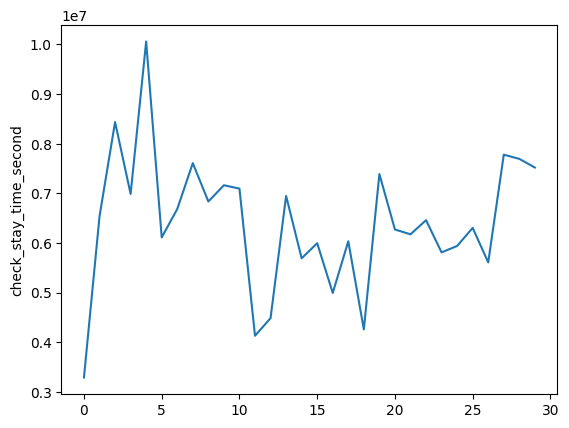

In [267]:
sns.lineplot(used_time['check_stay_time_second'])

In [268]:
used_time.to_csv('dataset/office_used_time.csv')

In [ ]:
used_2month_avg = used_time['check_stay_time_second'].rolling(window=2).mean()
used_2month_avg[1:]

In [ ]:
sns.lineplot(used_2month_avg[1:])

#### 데이터 노이즈추가로 더하기!

In [271]:
def augment_data(df, column, percentage): 
    augmented_data = df.copy() # +- percentage 범위 내의 오차를 추가 
    augmented_data[column] = df[column] * (1 + np.random.uniform(-percentage, percentage, df.shape[0]))
    return augmented_data

augmented_data = augment_data(ml_data, 'check_stay_time_second', 0.05)

augmented_data['check_stay_time_second'] = augmented_data['check_stay_time_second'].astype(int)

augmented_data = augmented_data.groupby('user_uuid').agg({
    'site_id' : lambda x: x.mode()[0],
    'area_pyeong' : 'max',
    'date' : 'count',                       # 사용일자 합산
    'check_stay_time_second': 'sum',        # 사용 시간 합산
    'year': 'max',                          # 가장 최신의 연도 사용
    'month': 'max',                         # 가장 최신의 월 사용
    'season': lambda x: x.mode()[0],        # 가장 많이 등장한 계절
    'time_of_day': lambda x: x.mode()[0],   # 가장 많이 등장한 시간대
    'is_payment': 'max'                     # 결제 여부(1이 있는 경우 결제한 것으로 가정)
}).reset_index()

In [273]:
uniform_df = pd.concat([aggregated_df, augmented_data], ignore_index=True)
uniform_df.to_csv('dataset/uniform_noise_df.csv')

#### 가우시안 노이즈 추가


In [274]:
# 가우시안 노이즈 추가 (평균 0, 표준 편차가 원본 값의 5%에 해당하는 노이즈)
aggregated_df2 = aggregated_df.copy(deep=True)
mean = 0
std_dev = 0.05 * aggregated_df2['check_stay_time_second'].std() # 원본 값의 5%
aggregated_df2['check_stay_time_second'] += np.random.normal(mean, std_dev, size=aggregated_df2['check_stay_time_second'].shape)
aggregated_df2['check_stay_time_second'] = aggregated_df2['check_stay_time_second'].astype(int)

In [275]:
# 가우시안 노이즈 추가 (평균 0, 표준 편차가 원본 값의 5%에 해당하는 노이즈)
aggregated_df3 = aggregated_df.copy(deep=True)
mean = 0
std_dev = 0.05 * aggregated_df3['check_stay_time_second'].std() # 원본 값의 5%
aggregated_df3['check_stay_time_second'] += np.random.normal(mean, std_dev, size=aggregated_df3['check_stay_time_second'].shape)
aggregated_df3['check_stay_time_second'] = aggregated_df3['check_stay_time_second'].astype(int)

In [276]:
# 가우시안 노이즈 추가 (평균 0, 표준 편차가 원본 값의 5%에 해당하는 노이즈)
aggregated_df4 = aggregated_df.copy(deep=True)
mean = 0
std_dev = 0.05 * aggregated_df4['check_stay_time_second'].std() # 원본 값의 5%
aggregated_df4['check_stay_time_second'] += np.random.normal(mean, std_dev, size=aggregated_df4['check_stay_time_second'].shape)
aggregated_df4['check_stay_time_second'] = aggregated_df4['check_stay_time_second'].astype(int)

In [277]:
# 가우시안 노이즈 추가 (평균 0, 표준 편차가 원본 값의 5%에 해당하는 노이즈)
aggregated_df5 = aggregated_df.copy(deep=True)
mean = 0
std_dev = 0.05 * aggregated_df5['check_stay_time_second'].std() # 원본 값의 5%
aggregated_df5['check_stay_time_second'] += np.random.normal(mean, std_dev, size=aggregated_df5['check_stay_time_second'].shape)
aggregated_df5['check_stay_time_second'] = aggregated_df5['check_stay_time_second'].astype(int)

In [279]:
dummy_df = pd.concat([aggregated_df, aggregated_df2], ignore_index=True)
# dummy_df = pd.concat([aggregated_df, aggregated_df2, aggregated_df3, aggregated_df4, aggregated_df5], ignore_index=True)

gaussian_df = dummy_df.to_csv('dataset/gaussian_noise_df.csv')

## Data EDA

In [ ]:
ml_data.head()

In [ ]:
aggregated_df['check_stay_time_second'].describe()
# q1 = aggregated_df['check_stay_time_second'].quantile(0.25)
# q3 = aggregated_df['check_stay_time_second'].quantile(0.75)
# display(q1,q3)

# iqr = q3 - q1
# lower = q1 - (1.5*iqr)
# upper = q3 + (1.5*iqr)

# filtered_aggregated_df = aggregated_df[~((aggregated_df['check_stay_time_second'] < lower) | (aggregated_df['check_stay_time_second'] > upper))]
# filtered_aggregated_df

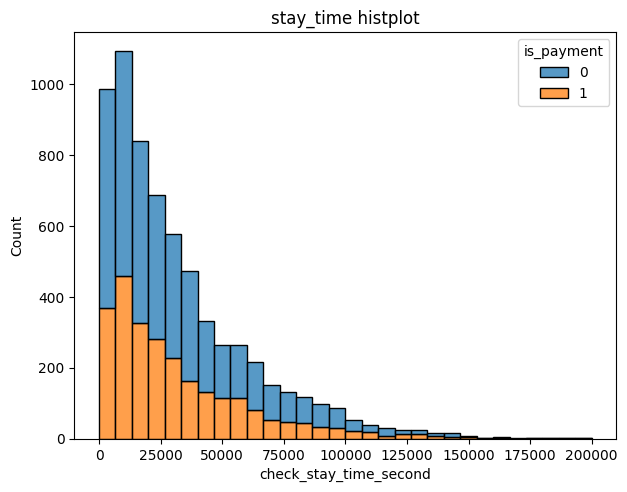

In [283]:
sns.histplot(data = aggregated_df, x = 'check_stay_time_second', bins = 30, hue='is_payment', multiple='stack')
plt.tight_layout()
plt.title(f'stay_time histplot')
plt.show()

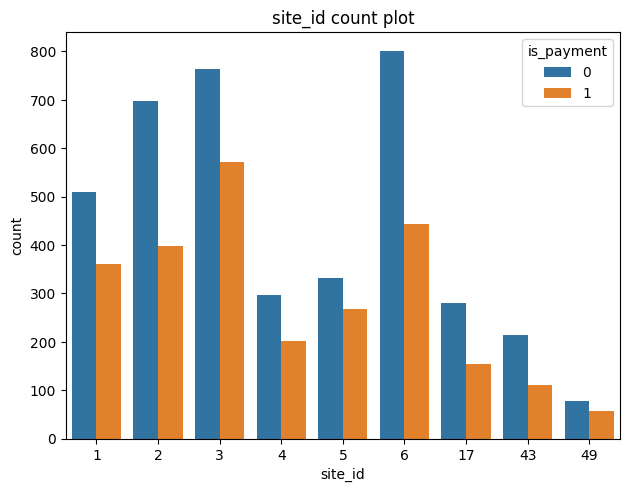

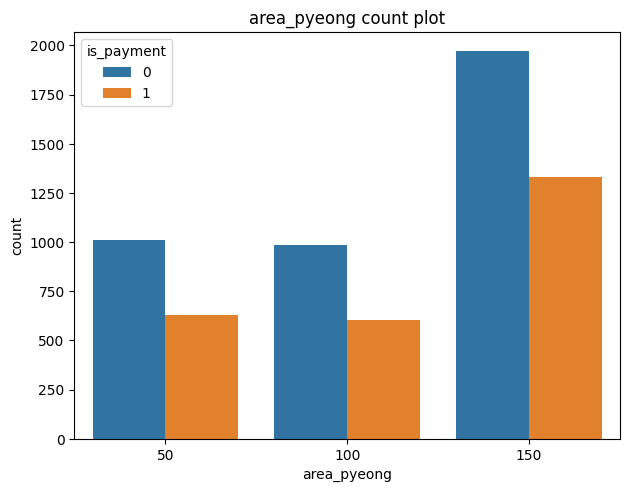

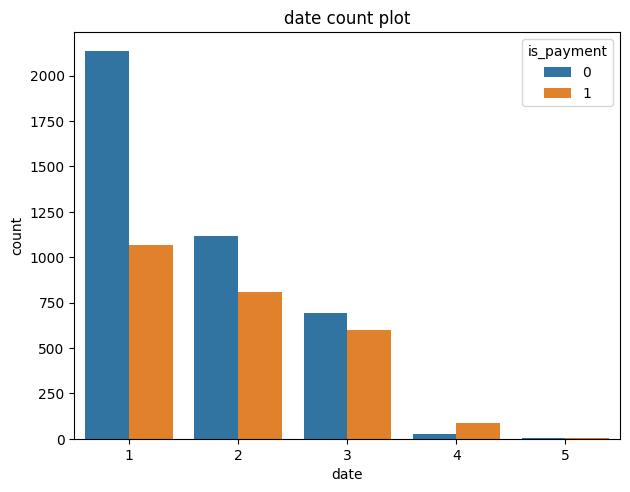

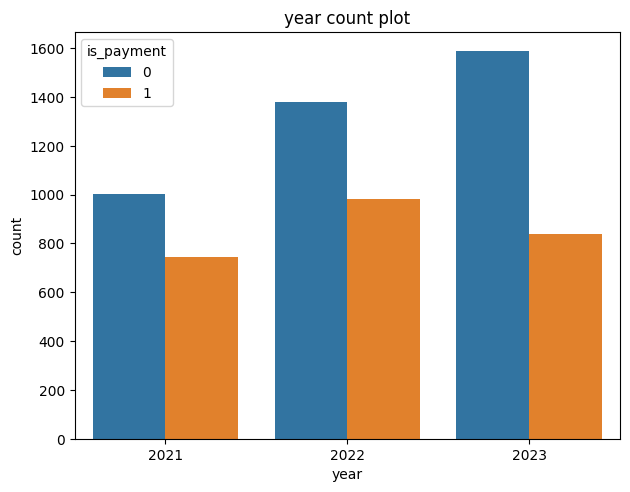

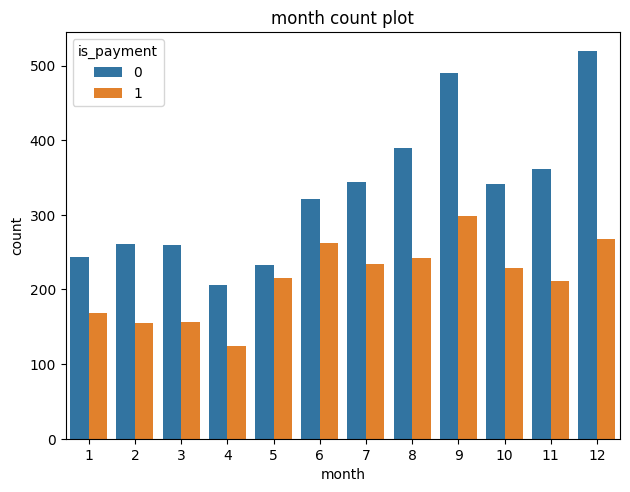

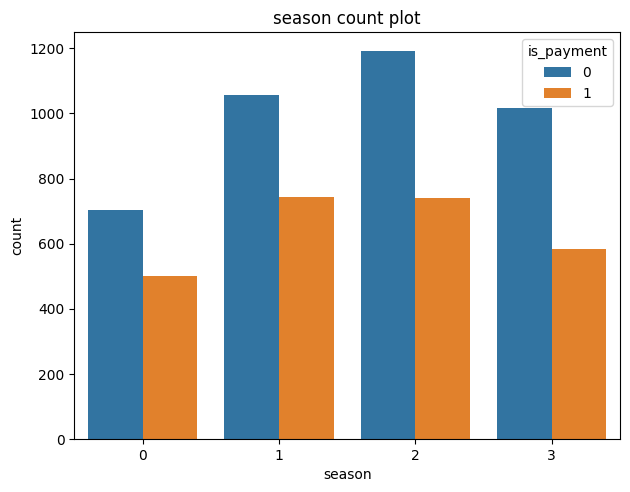

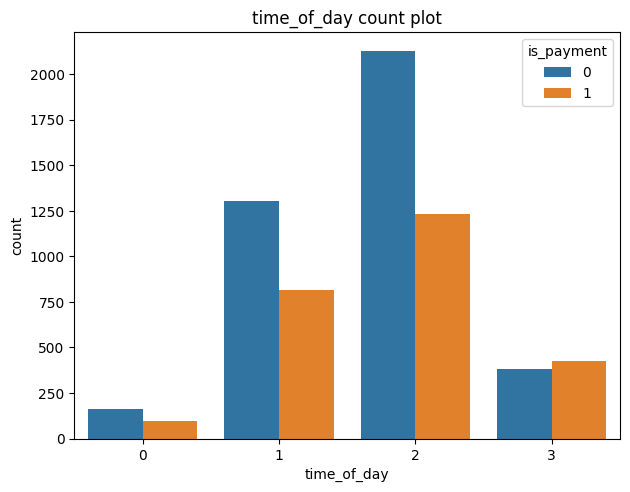

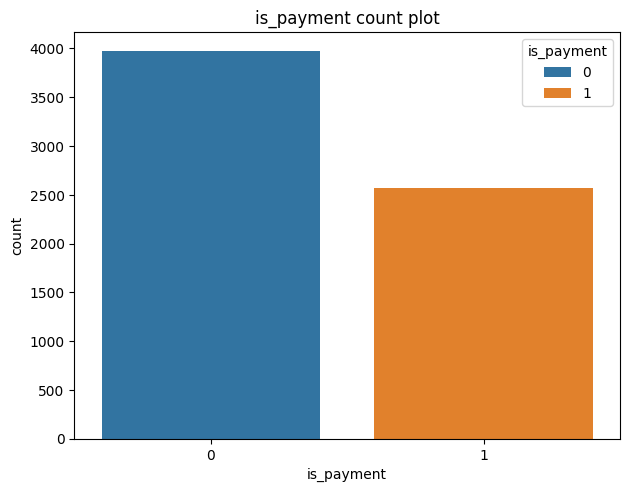

In [284]:
for idx in aggregated_df.drop(columns=['check_stay_time_second', 'user_uuid']).columns:
    sns.countplot(data = aggregated_df, x=idx, hue='is_payment')
    plt.tight_layout()
    plt.title(f'{idx} count plot')
    plt.show()

## ML Modeling

### Setting Data

In [285]:
drop_col = ['user_uuid', 'is_payment']
X = dummy_df.copy(deep=True)
X = X.drop(columns=drop_col)
y = dummy_df['is_payment']

In [ ]:
y.value_counts()

              precision    recall  f1-score   support

           0       0.65      0.88      0.75      2008
           1       0.58      0.26      0.35      1259

    accuracy                           0.64      3267
   macro avg       0.62      0.57      0.55      3267
weighted avg       0.62      0.64      0.60      3267

정확도: 0.6412610958065503


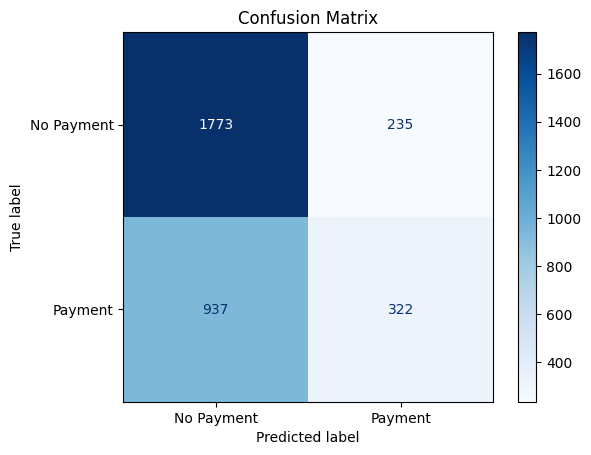

In [288]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 특성 스케일링 (표준화)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression 모델 학습
# lr = LogisticRegression(class_weight={0 : 20, 1: 20}, random_state=42)
lr = LogisticRegression(random_state=42)

lr.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred = lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(f"정확도: {accuracy_score(y_test, y_pred)}")

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Payment", "Payment"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [289]:

dt = DecisionTreeClassifier(
    random_state=20,
)

# parameter
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2, 4, 5, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6],
    'max_features': [None, 'sqrt', 'log2'],
    # 'max_leaf_nodes' : list(range(1, 100, 5))
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2,
    )

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print(f'Train :  {grid_search.score(X_train, y_train)}')
print(f'Test :  {grid_search.score(X_test, y_test)}')

# Best parameters
best_param = grid_search.best_params_
print("Best parameters found: ", best_param)


Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Train :  0.7039077645138251
Test :  0.6587082950719314
Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}


모델명: Logistic Regression
              precision    recall  f1-score   support

           0       0.65      0.88      0.75      2008
           1       0.58      0.26      0.35      1259

    accuracy                           0.64      3267
   macro avg       0.62      0.57      0.55      3267
weighted avg       0.62      0.64      0.60      3267

정확도: 0.6412610958065503



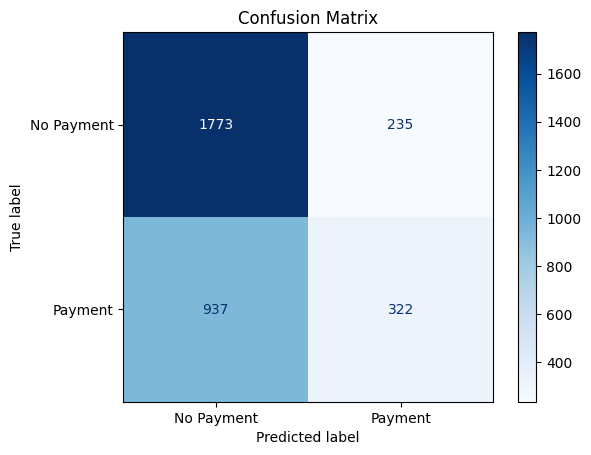

모델명: SGD Classifier
              precision    recall  f1-score   support

           0       0.61      0.99      0.76      2008
           1       0.23      0.00      0.01      1259

    accuracy                           0.61      3267
   macro avg       0.42      0.50      0.38      3267
weighted avg       0.46      0.61      0.47      3267

정확도: 0.61095806550352



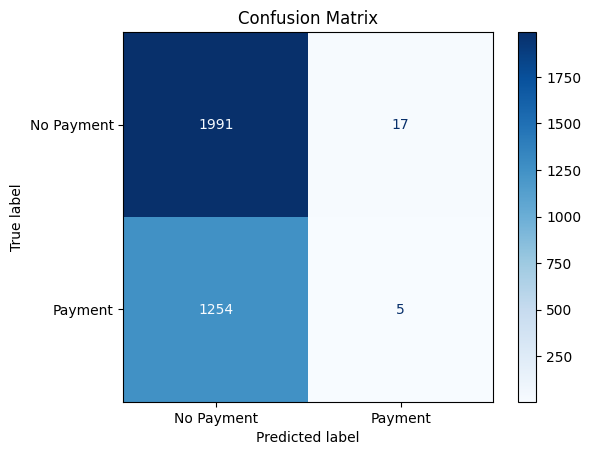

모델명: KNN
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      2008
           1       0.60      0.52      0.55      1259

    accuracy                           0.68      3267
   macro avg       0.66      0.65      0.65      3267
weighted avg       0.67      0.68      0.67      3267

정확도: 0.679828588919498



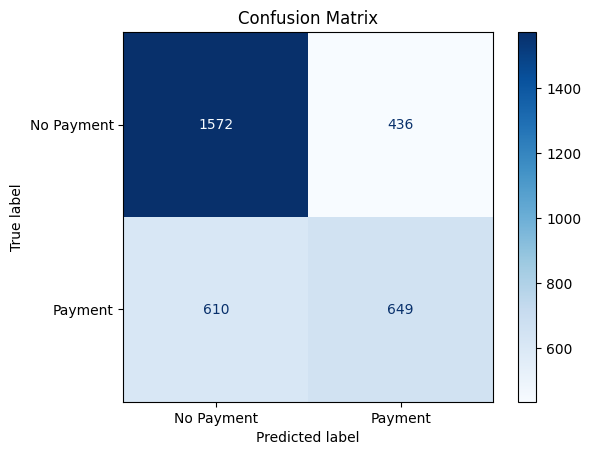

모델명: SVM
              precision    recall  f1-score   support

           0       0.65      0.91      0.76      2008
           1       0.62      0.23      0.33      1259

    accuracy                           0.65      3267
   macro avg       0.64      0.57      0.55      3267
weighted avg       0.64      0.65      0.60      3267

정확도: 0.6489133761861035



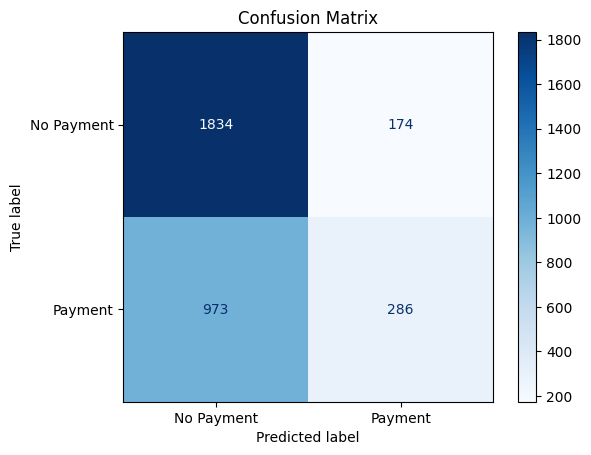

모델명: Naive Bayes
              precision    recall  f1-score   support

           0       0.62      0.98      0.76      2008
           1       0.55      0.04      0.07      1259

    accuracy                           0.62      3267
   macro avg       0.58      0.51      0.41      3267
weighted avg       0.59      0.62      0.49      3267

정확도: 0.6170798898071626



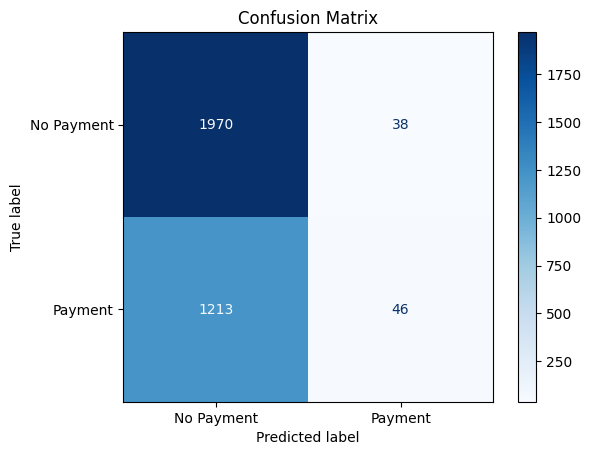

모델명: Random Forest
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      2008
           1       0.75      0.71      0.73      1259

    accuracy                           0.80      3267
   macro avg       0.79      0.78      0.78      3267
weighted avg       0.80      0.80      0.80      3267

정확도: 0.7970615243342516



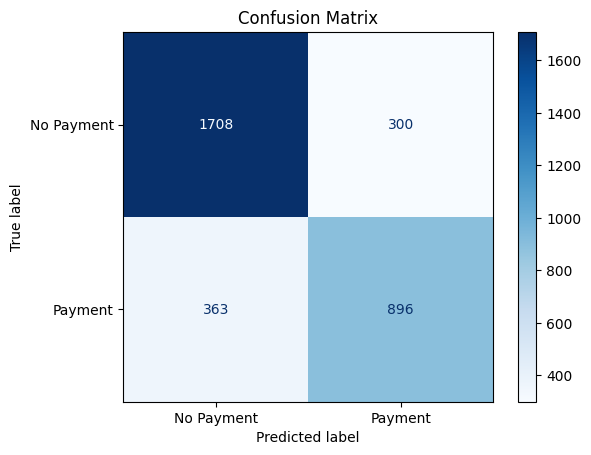

모델명: XGBoost
              precision    recall  f1-score   support

           0       0.71      0.83      0.76      2008
           1       0.63      0.46      0.53      1259

    accuracy                           0.69      3267
   macro avg       0.67      0.65      0.65      3267
weighted avg       0.68      0.69      0.68      3267

정확도: 0.6868686868686869



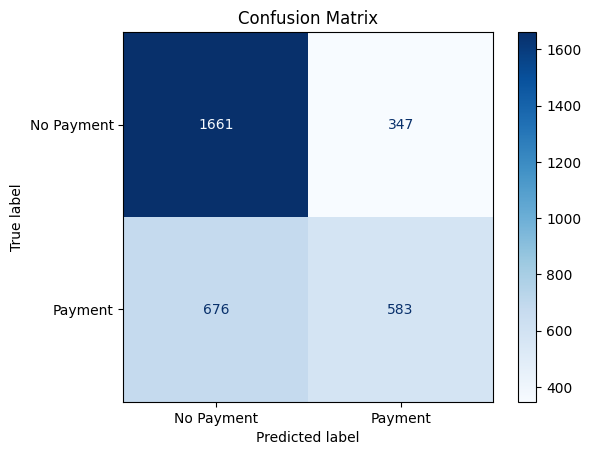

모델명: CatBoost
              precision    recall  f1-score   support

           0       0.70      0.86      0.77      2008
           1       0.65      0.40      0.50      1259

    accuracy                           0.69      3267
   macro avg       0.67      0.63      0.63      3267
weighted avg       0.68      0.69      0.67      3267

정확도: 0.6853382307927762



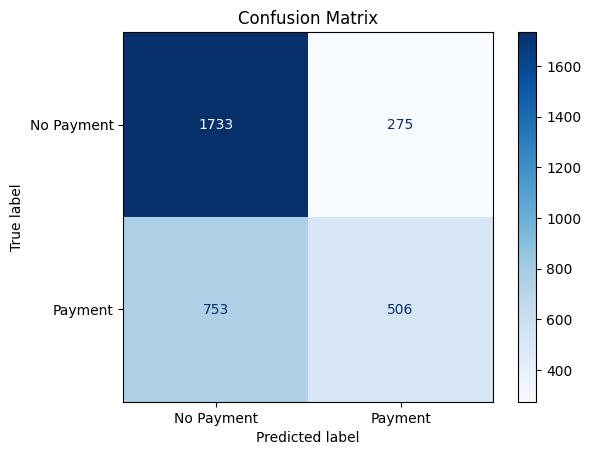

In [290]:
# 피쳐 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

# 여러 모델 지정, dictionary
models = {
    'Logistic Regression': LogisticRegression(),
    'SGD Classifier': SGDClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(silent=True)
}

scale_need_model = ['KNN', 'SVM', 'Logistic Regression', 'Random Forest', 'XGBoost']

# 모델 학습 및 평가
for model_name, model in models.items():
    if model_name in scale_need_model:  # 스케일된 특징 사용
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    else:
        model.fit(X_train, y_train)  # Naive Bayes 및 CatBoost는 스케일링 필요 없음
        y_pred = model.predict(X_test)

    # 분류 보고서
    print(f"모델명: {model_name}")
    print(classification_report(y_test, y_pred))
    accuracy = model.score(X_test_scaled if model_name in scale_need_model else X_test, y_test)
    print(f"정확도: {accuracy}")
    print()
    # 혼동 행렬 계산
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 시각화
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Payment", "Payment"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


### GridSearchCV

In [291]:

# 여러 모델 지정, dictionary
models = {
    'Logistic Regression': LogisticRegression(),
    'SGD Classifier': SGDClassifier(loss='log', class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(silent=True),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier()
}


-------------------- Logistic Regression --------------------
최적 파라미터: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}
              precision    recall  f1-score   support

           0       0.65      0.88      0.75      2008
           1       0.58      0.25      0.35      1259

    accuracy                           0.64      3267
   macro avg       0.62      0.57      0.55      3267
weighted avg       0.62      0.64      0.60      3267

정확도: 0.6409550045913682
ROC AUC Score: 0.6237729779848042


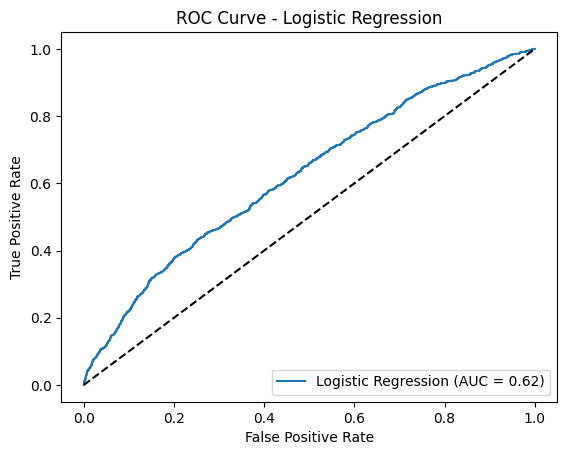

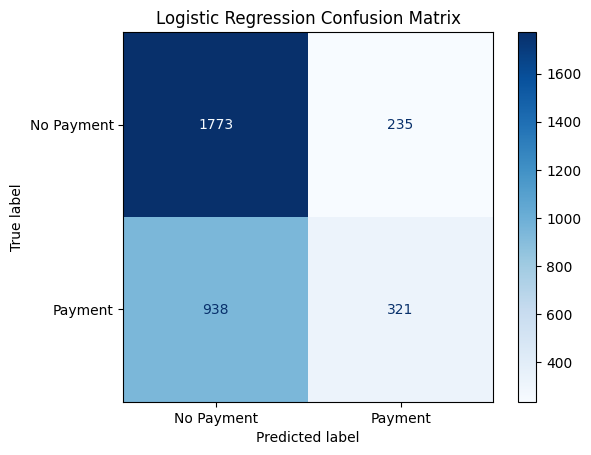

------------------------------------------------------------

-------------------- SGD Classifier --------------------
최적 파라미터: {'max_iter': 200, 'loss': 'hinge', 'alpha': 0.001}
              precision    recall  f1-score   support

           0       0.61      1.00      0.76      2008
           1       0.00      0.00      0.00      1259

    accuracy                           0.61      3267
   macro avg       0.31      0.50      0.38      3267
weighted avg       0.38      0.61      0.47      3267

정확도: 0.6140189776553413
SGD Classifier는 ROC AUC를 지원하지 않습니다.



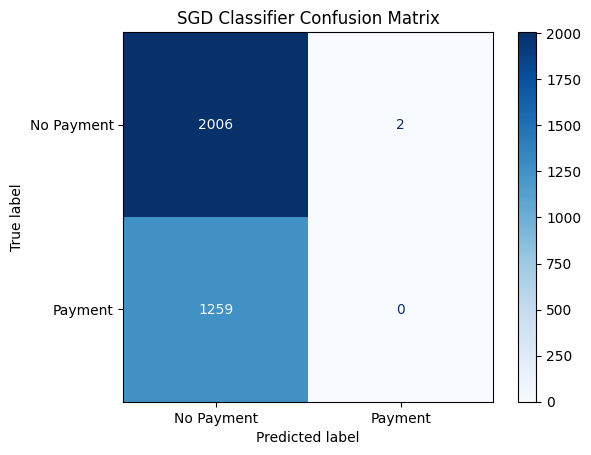

------------------------------------------------------------

-------------------- KNN --------------------
최적 파라미터: {'weights': 'distance', 'n_neighbors': 3}
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2008
           1       0.74      0.71      0.73      1259

    accuracy                           0.79      3267
   macro avg       0.78      0.78      0.78      3267
weighted avg       0.79      0.79      0.79      3267

정확도: 0.7936945209672482
ROC AUC Score: 0.8433834162951054


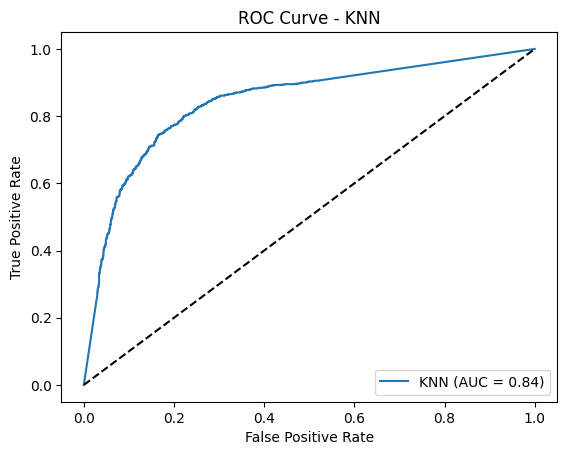

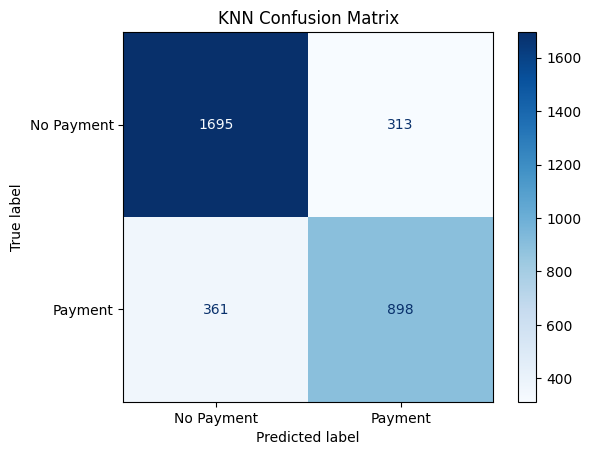

------------------------------------------------------------

-------------------- SVM --------------------
최적 파라미터: {'kernel': 'rbf', 'C': 1}
              precision    recall  f1-score   support

           0       0.71      0.67      0.69      2008
           1       0.52      0.57      0.54      1259

    accuracy                           0.63      3267
   macro avg       0.61      0.62      0.61      3267
weighted avg       0.64      0.63      0.63      3267

정확도: 0.6284052647689011
ROC AUC Score: 0.6585239660895734


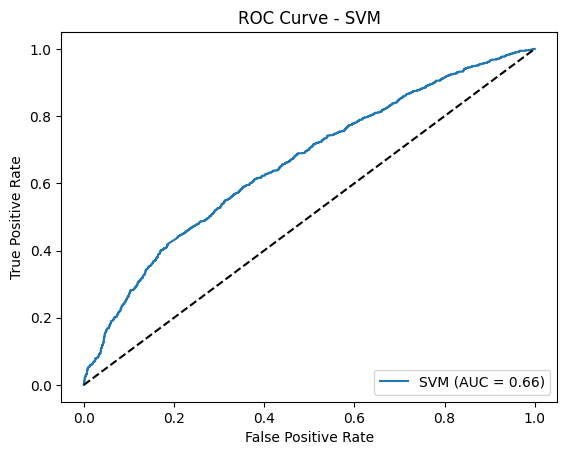

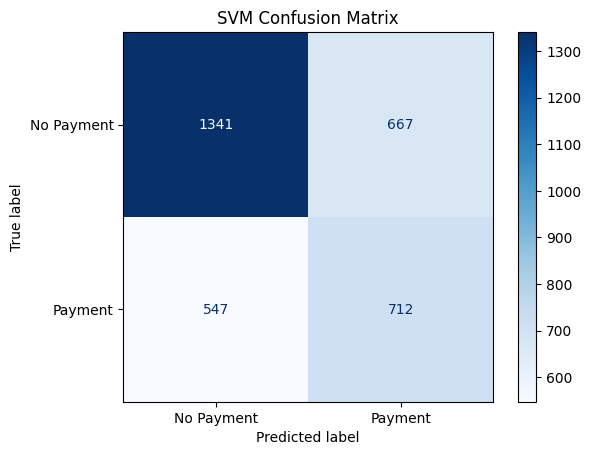

------------------------------------------------------------

-------------------- Naive Bayes --------------------
최적 파라미터: {}
              precision    recall  f1-score   support

           0       0.62      0.98      0.76      2008
           1       0.55      0.04      0.07      1259

    accuracy                           0.62      3267
   macro avg       0.58      0.51      0.41      3267
weighted avg       0.59      0.62      0.49      3267

정확도: 0.6170798898071626
ROC AUC Score: 0.5876058909714597


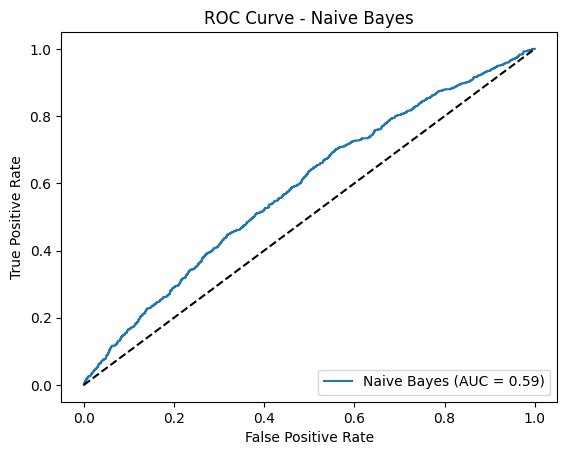

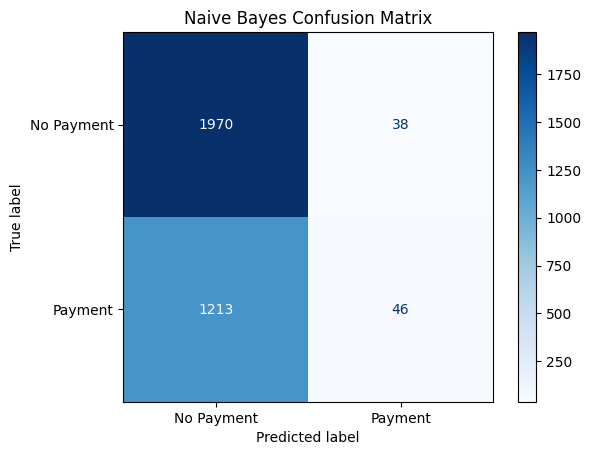

------------------------------------------------------------

-------------------- Random Forest --------------------
최적 파라미터: {'n_estimators': 200, 'max_depth': 20}
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      2008
           1       0.75      0.72      0.73      1259

    accuracy                           0.80      3267
   macro avg       0.79      0.78      0.79      3267
weighted avg       0.80      0.80      0.80      3267

정확도: 0.7998163452708907
ROC AUC Score: 0.8430369071766944


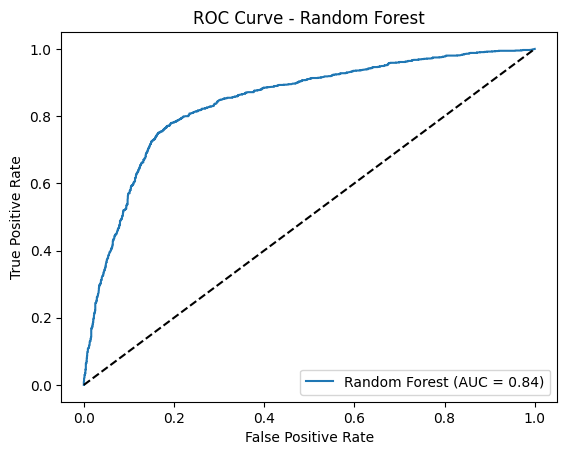

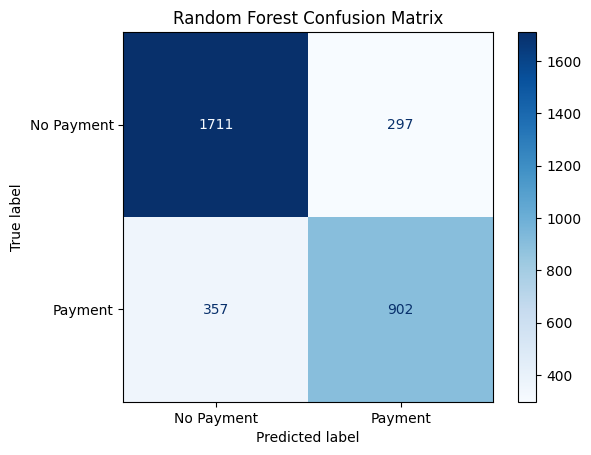

------------------------------------------------------------

-------------------- XGBoost --------------------
최적 파라미터: {'n_estimators': 100, 'learning_rate': 0.2}
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      2008
           1       0.62      0.43      0.51      1259

    accuracy                           0.68      3267
   macro avg       0.66      0.63      0.63      3267
weighted avg       0.67      0.68      0.66      3267

정확도: 0.6779920416284053
ROC AUC Score: 0.7068888860760295


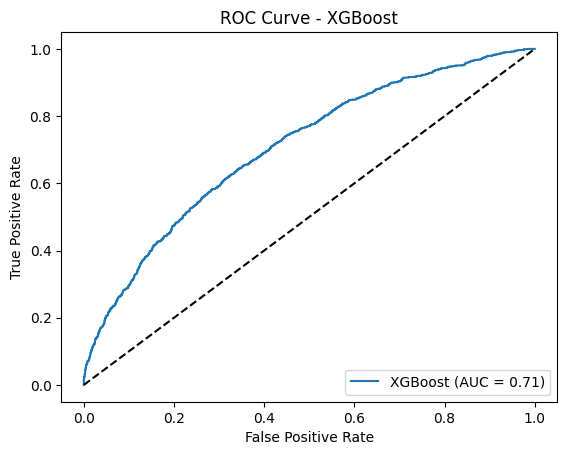

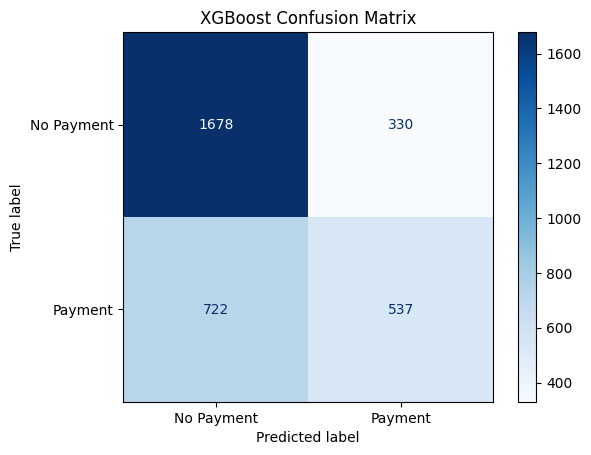

------------------------------------------------------------

-------------------- CatBoost --------------------
최적 파라미터: {'learning_rate': 0.1, 'iterations': 200}
              precision    recall  f1-score   support

           0       0.69      0.86      0.77      2008
           1       0.63      0.39      0.48      1259

    accuracy                           0.68      3267
   macro avg       0.66      0.62      0.62      3267
weighted avg       0.67      0.68      0.66      3267

정확도: 0.677379859198041
ROC AUC Score: 0.7112230189646497


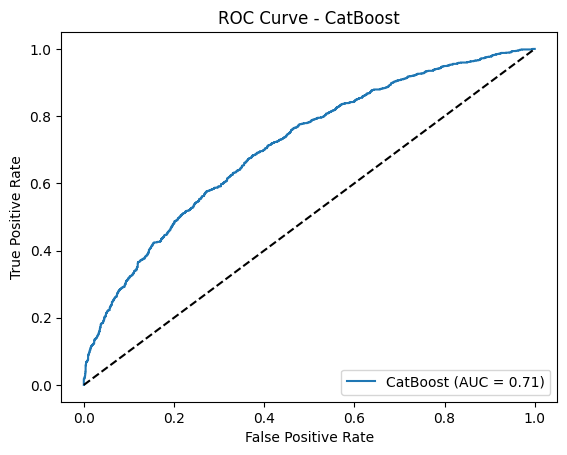

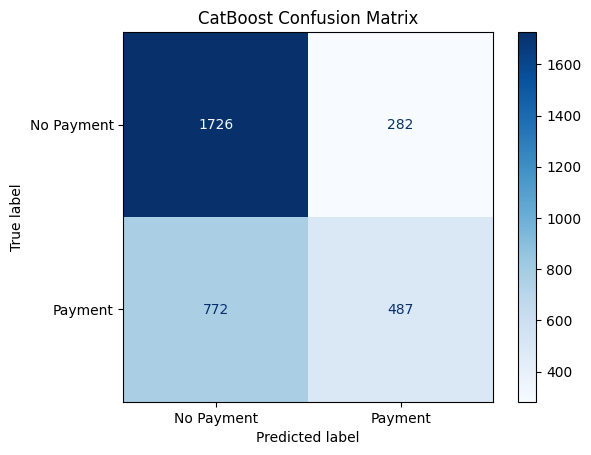

------------------------------------------------------------

-------------------- Gradient Boosting --------------------
최적 파라미터: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.68      0.84      0.75      2008
           1       0.59      0.37      0.45      1259

    accuracy                           0.66      3267
   macro avg       0.63      0.60      0.60      3267
weighted avg       0.64      0.66      0.64      3267

정확도: 0.6571778389960208
ROC AUC Score: 0.6872353714609395


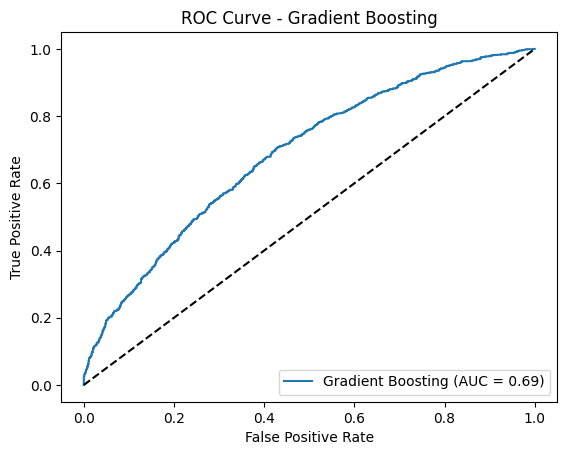

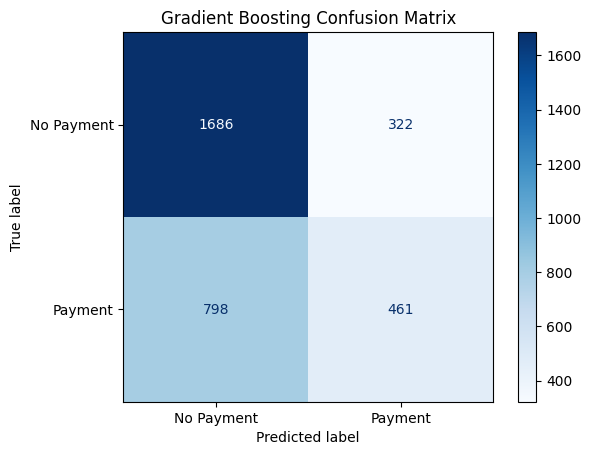

------------------------------------------------------------

-------------------- AdaBoost --------------------
최적 파라미터: {'n_estimators': 100, 'learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.63      0.95      0.76      2008
           1       0.61      0.13      0.21      1259

    accuracy                           0.63      3267
   macro avg       0.62      0.54      0.48      3267
weighted avg       0.62      0.63      0.55      3267

정확도: 0.6314661769207224
ROC AUC Score: 0.6363062444424052


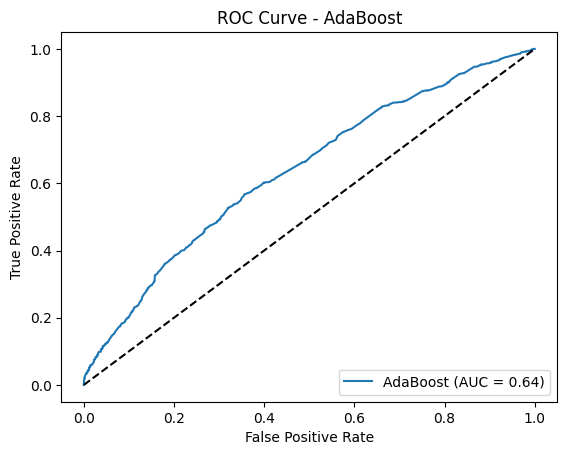

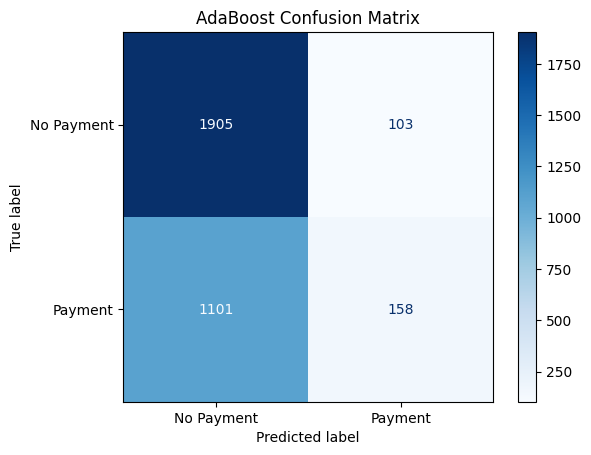

------------------------------------------------------------


In [292]:

# 하이퍼파라미터 그리드 설정 
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
    'SGD Classifier': {'alpha': [0.001, 0.01], 'max_iter': [200, 400], 'loss': ['hinge', 'log']},
    'KNN': {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']},
    'SVM': {'C': [0.1, 1], 'kernel': ['linear', 'rbf']},
    'Naive Bayes': {},  # Naive Bayes는 기본 파라미터 사용
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20]},
    'XGBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 0.2]},
    'CatBoost': {'iterations': [100, 200], 'learning_rate': [0.01, 0.1]},
    'Gradient Boosting': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
    'AdaBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
}

# scale_need_model = ['KNN', 'Logistic Regression', 'Random Forest', 'XGBoost']
scale_need_model = ['KNN', 'SVM', 'Logistic Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting', 'AdaBoost']

# 모델 학습 및 평가
for model_name, model in models.items():
    print(f"\n{'-'*20} {model_name} {'-'*20}")

    # 하이퍼파라미터 그리드가 정의되어 있을 경우 GridSearchCV 적용
    if model_name in param_grids:
        param_grid = param_grids[model_name]
        grid_search = RandomizedSearchCV(model, param_grid, cv=4, scoring='accuracy', n_jobs=-1)
        
        # 스케일된 데이터를 사용하는 모델
        if model_name in scale_need_model:
            grid_search.fit(X_train_scaled, y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test_scaled)
            y_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None
        else:
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
            y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

        print(f"최적 파라미터: {grid_search.best_params_}")

    else:  # GridSearchCV를 적용하지 않는 모델은 그대로 사용
        if model_name in scale_need_model:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # 분류 보고서
    print(classification_report(y_test, y_pred))
    accuracy = best_model.score(X_test_scaled if model_name in scale_need_model else X_test, y_test)
    print(f"정확도: {accuracy}")

    # ROC AUC 확인 (SGD Classifier는 predict_proba가 없어 예외처리)
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"ROC AUC Score: {roc_auc}")
        # ROC Curve 시각화
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print(f"{model_name}는 ROC AUC를 지원하지 않습니다.")
    
    print()
    # 혼동 행렬 계산
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 시각화
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Payment", "Payment"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    print("-" * 60)
